In [1]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("token")

In [2]:
!git clone https://github.com/SilverSurferClash/ML_Best_Practices.git

fatal: destination path 'ML_Best_Practices' already exists and is not an empty directory.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA, NMF
from sklearn.manifold import TSNE
from umap import UMAP
from scipy.cluster.hierarchy import dendrogram, ward
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 100)



In [4]:
train = pd.read_csv(r'../input/playground-series-s3e13/train.csv')
test_1 = pd.read_csv(r'../input/playground-series-s3e13/test.csv')
orig_train = pd.read_csv(r'../input/vector-borne-disease-prediction/trainn.csv')

train.drop('id', axis = 1, inplace = True)
test = test_1.drop('id', axis = 1)

### Adversarial Validation

In [11]:
def adversarial_validation(label = 'Train-Test' ):

    adv_train = train.drop('prognosis', axis = 1)
    if label == 'Train-Test':
        adv_test = test.copy()
    else:
        adv_train = pd.concat([adv_train, test], ignore_index = True)
        adv_test = orig_train.drop('prognosis', axis = 1)

    adv_train['is_test'] = 0
    adv_test['is_test'] = 1

    adv = pd.concat([adv_train, adv_test], ignore_index = True)

    adv_shuffled = adv.sample(frac = 1)

    adv_X = adv_shuffled.drop('is_test', axis = 1)
    adv_y = adv_shuffled.is_test

    skf = StratifiedKFold(n_splits = 5, random_state = 42, shuffle = True)

    val_scores = []
    predictions = np.zeros(len(adv))

    for fold, (train_idx, val_idx) in enumerate(skf.split(adv_X, adv_y)):
    
        adv_lr = LogisticRegression(random_state = 42)    
        adv_lr.fit(adv_X.iloc[train_idx], adv_y.iloc[train_idx])
        
        val_preds = adv_lr.predict_proba(adv_X.iloc[val_idx])[:,1]
        predictions[val_idx] = val_preds
        val_score = roc_auc_score(adv_y.iloc[val_idx], val_preds)
        val_scores.append(val_score)
    
    fpr, tpr, _ = roc_curve(adv['is_test'], predictions)
    plt.figure(figsize = (10, 10), dpi = 300)
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--", label="Indistinguishable Datasets")
    sns.lineplot(x=fpr, y=tpr, label="Adversarial Validation Classifier")
    plt.title(f'{label} Validation = {np.mean(val_scores):.5f}', weight = 'bold', size = 17)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

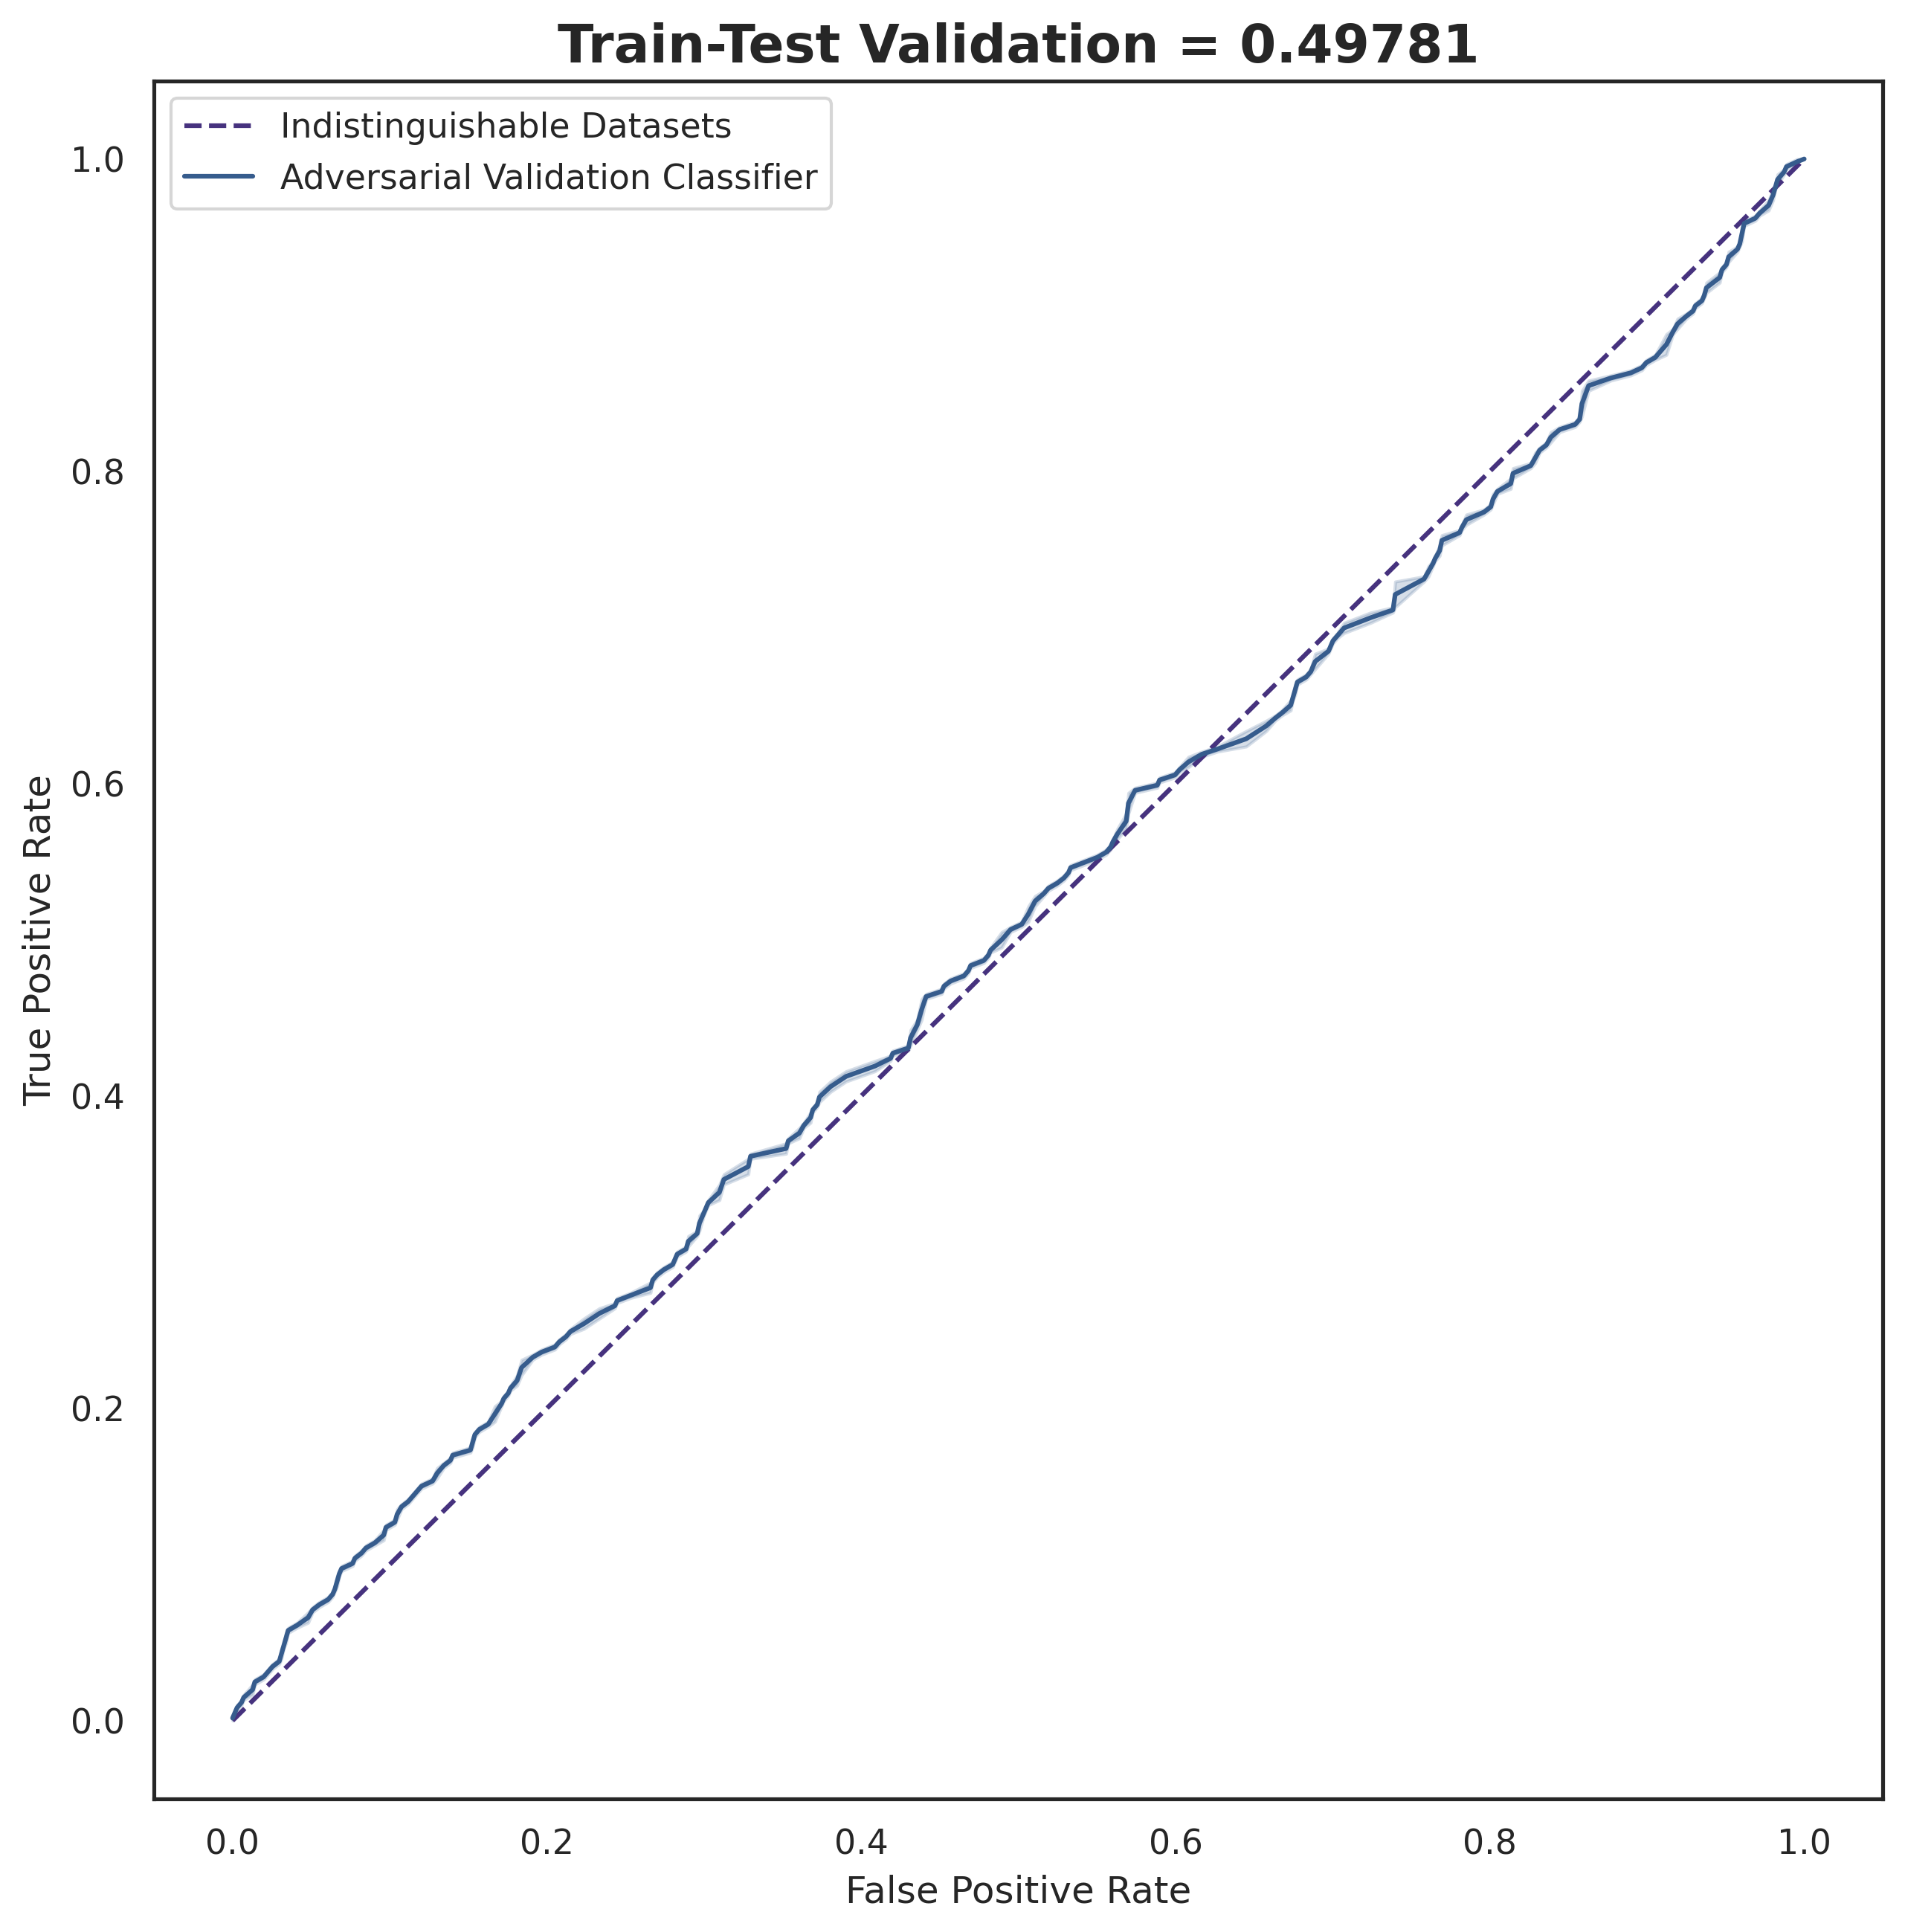

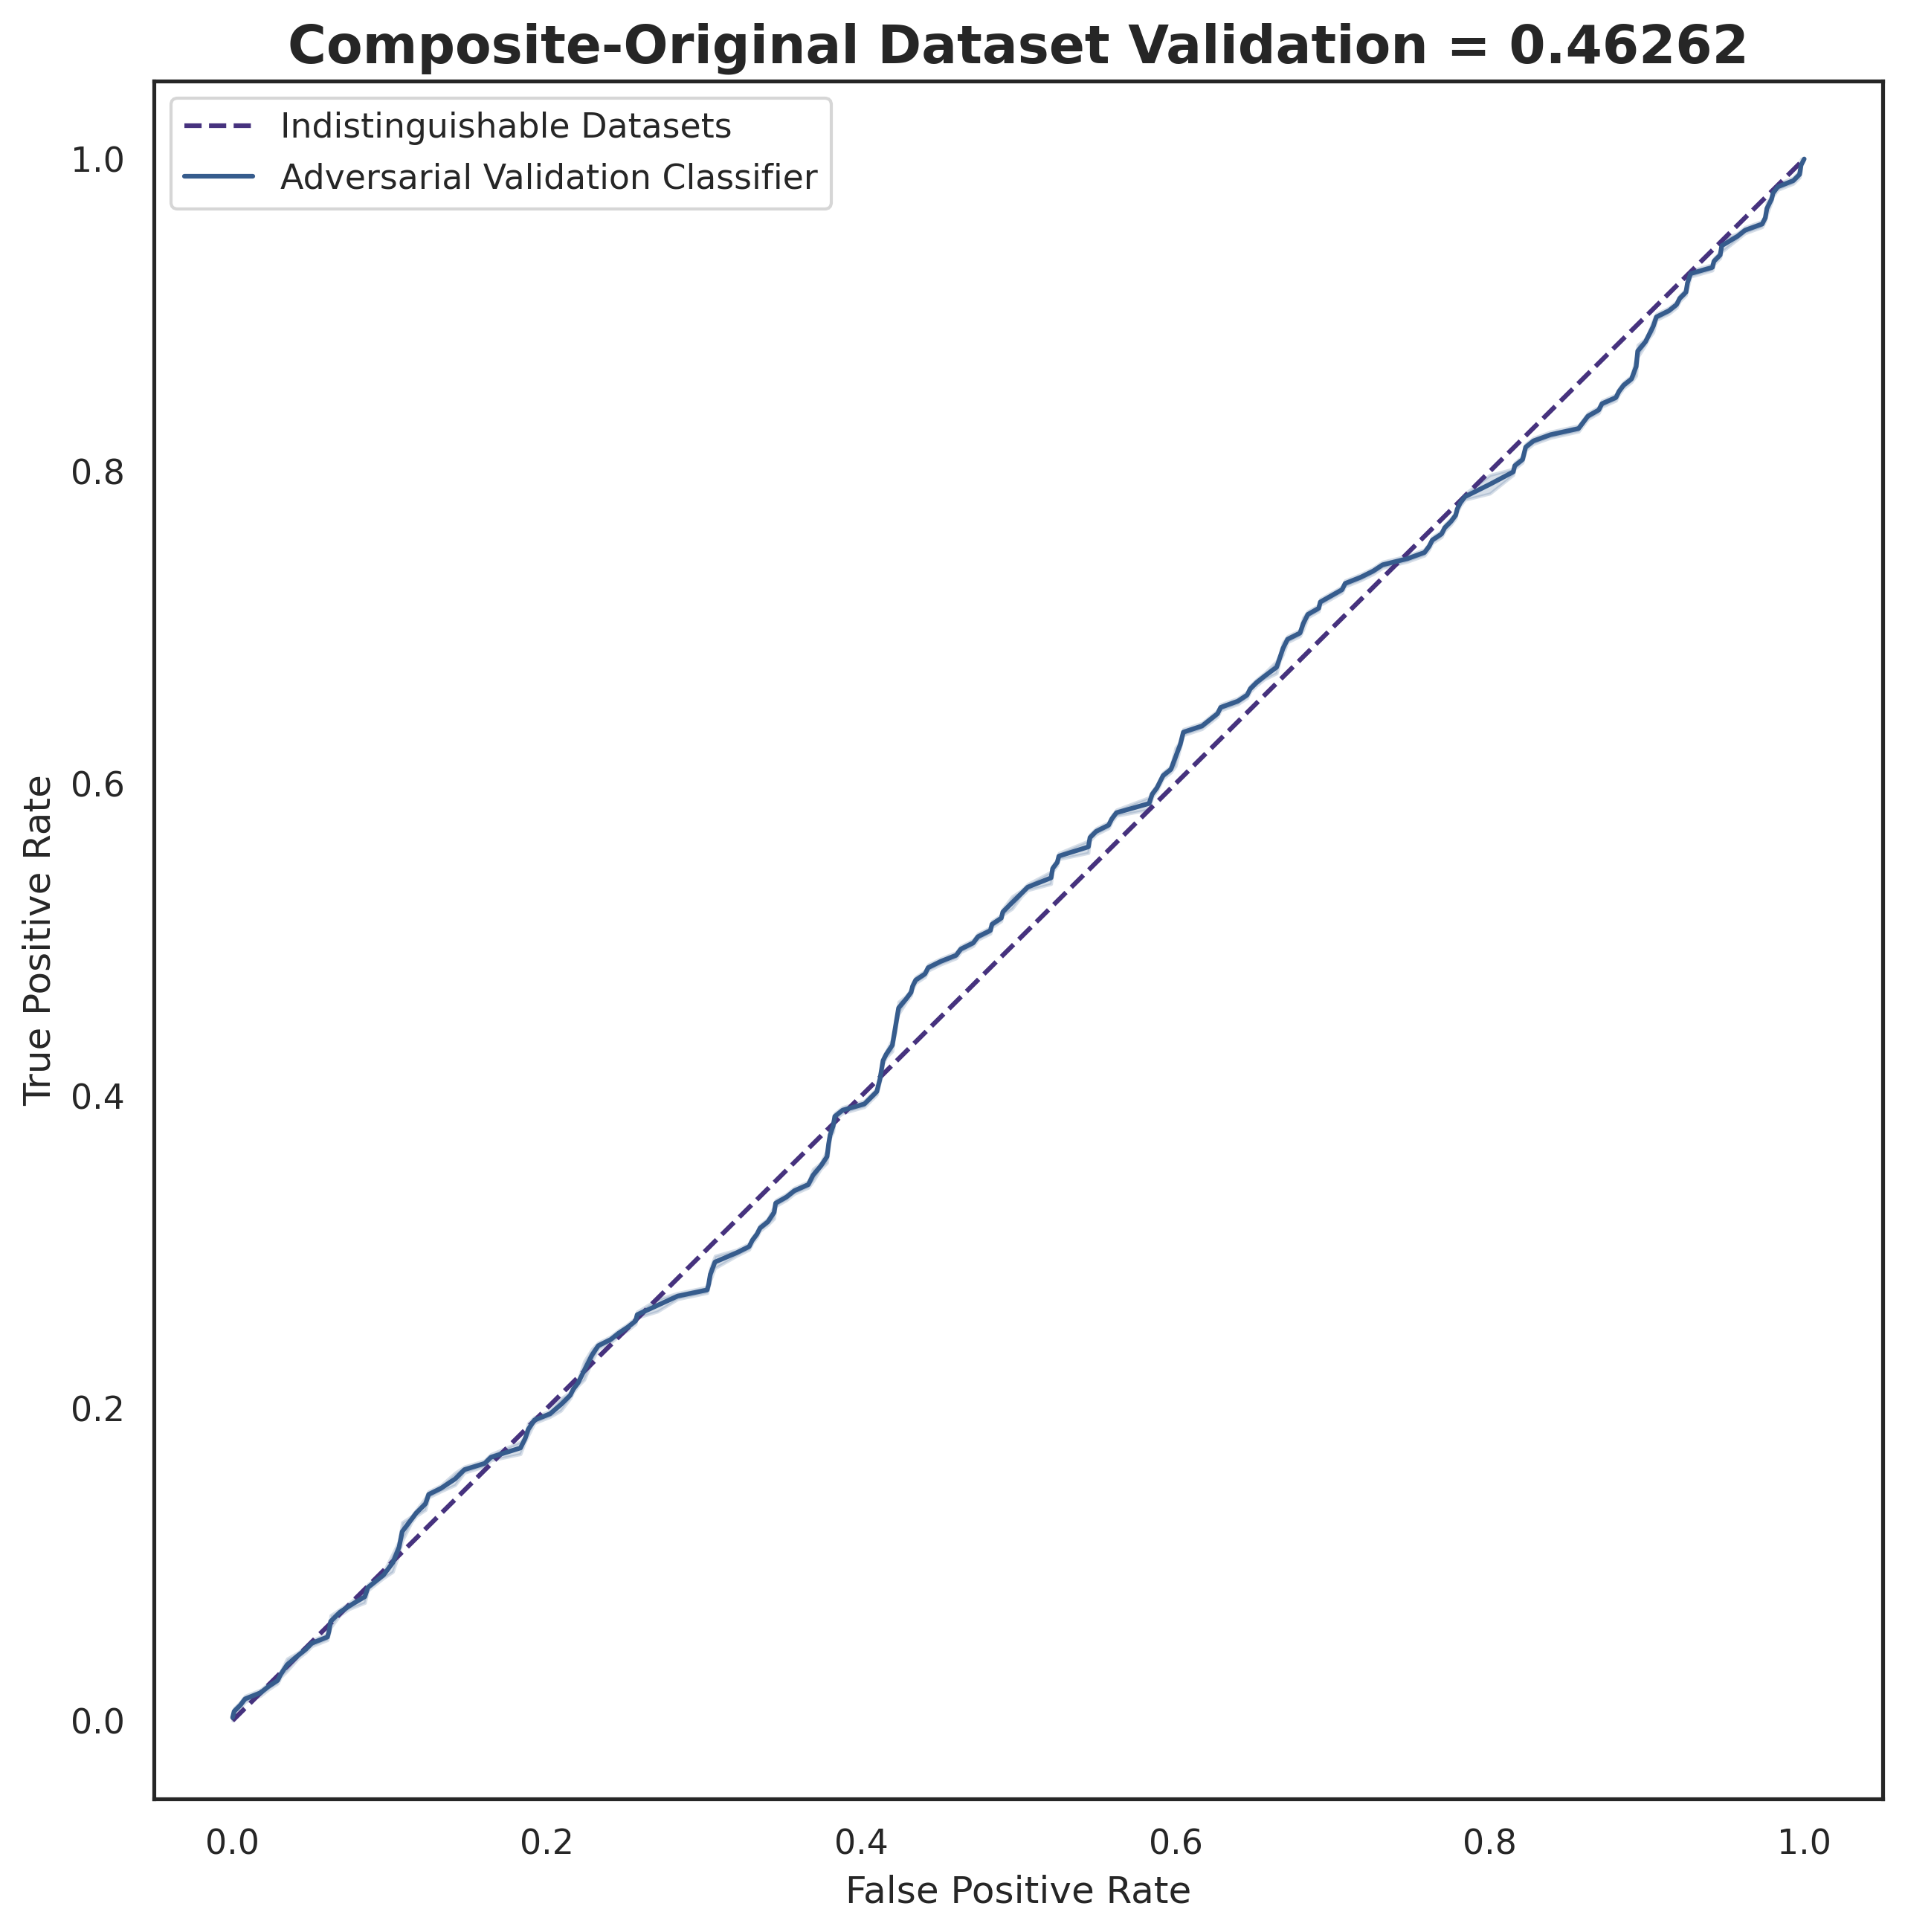

In [12]:
adversarial_validation()
adversarial_validation('Composite-Original Dataset')

### Analyze the target

(array([ 0., 10., 20., 30., 40., 50., 60., 70., 80., 90.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

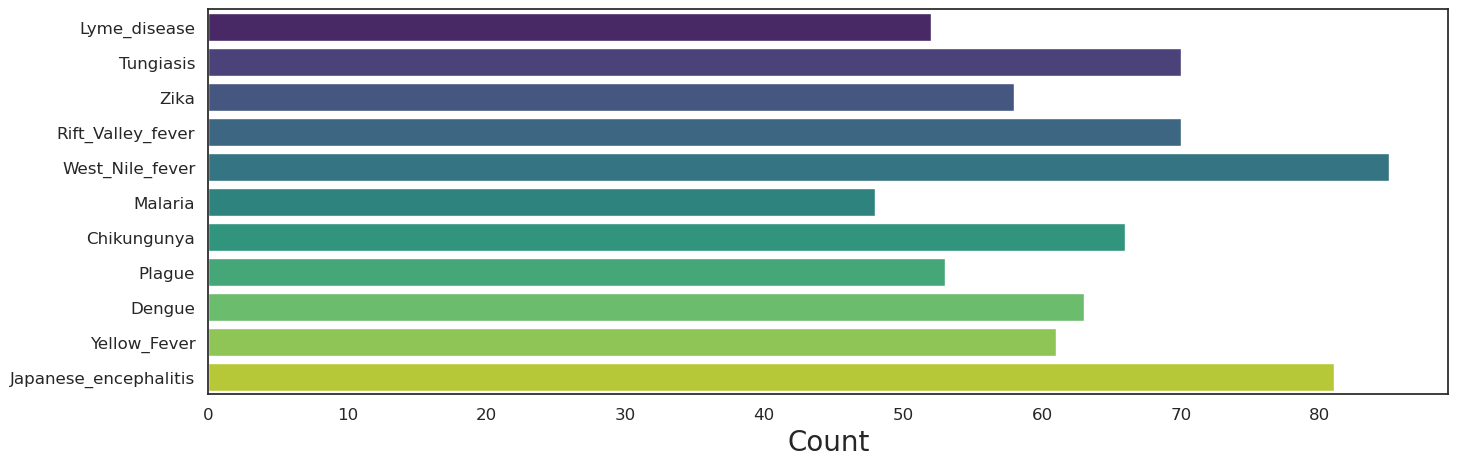

In [30]:
# Understand the distribution of the target
fig, ax = plt.subplots(1, 1, figsize = (16, 5))
#ax = ax.flatten() # Generate a numpy array with the length of the number of features to be plotted
sns.countplot(data = train, y = 'prognosis', ax = ax, palette = 'viridis', orient = "v")
ax.yaxis.label.set_size(20)
plt.yticks(fontsize = 12)
ax.set_xlabel('Count', fontsize = 20)
ax.set_ylabel(None)
plt.xticks(fontsize = 12)

In [18]:
type(ax), ax.shape

(numpy.ndarray, (4,))

In [31]:
#heatmap of correlations

def heatmap(dataset, label = None):
    corr = dataset.corr()
    plt.figure(figsize = (14, 10), dpi = 300)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = 'viridis')
    plt.yticks(fontsize = 5)
    plt.xticks(fontsize = 5)
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

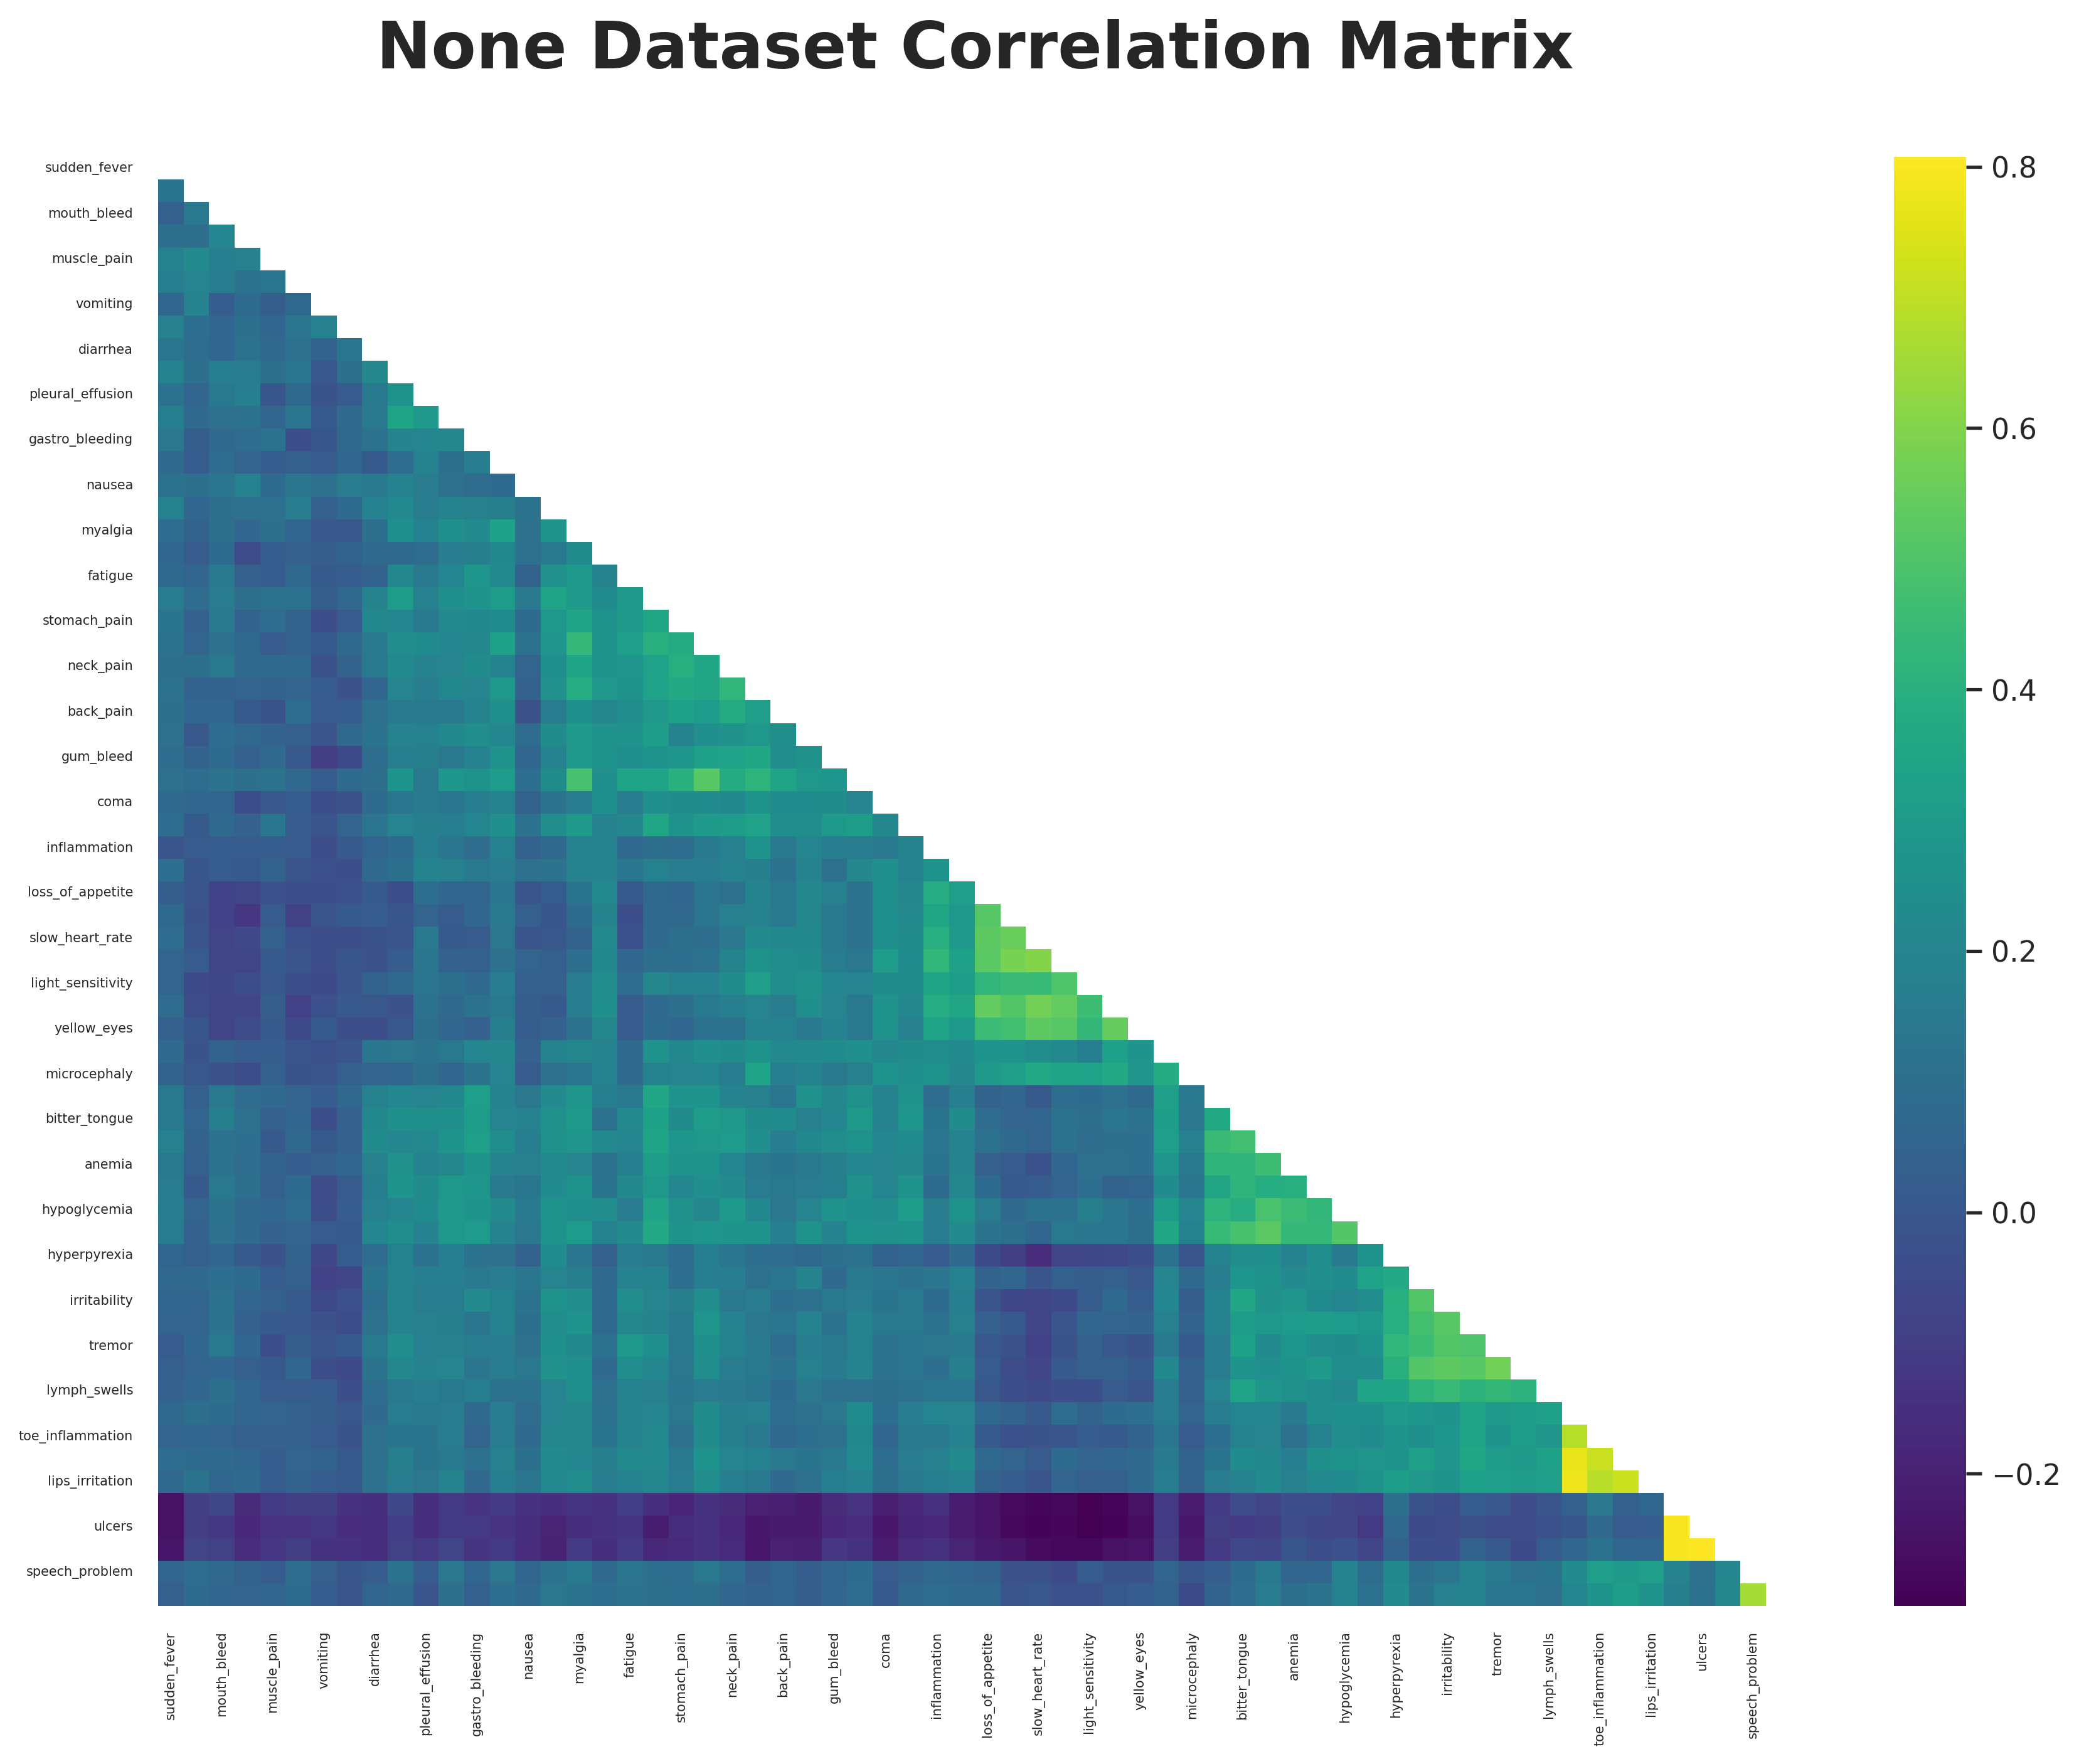

In [32]:
heatmap(train)

In [33]:
#Dendrogram

def distance(data, label = ''):
    distances = data.corr()
    dist_linkage = ward(distances)
    
    plt.figure(figsize = (10, 8), dpi = 300)
    dendro = dendrogram(dist_linkage, labels=test.columns, leaf_rotation=90)
    plt.title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 22)
    plt.show()

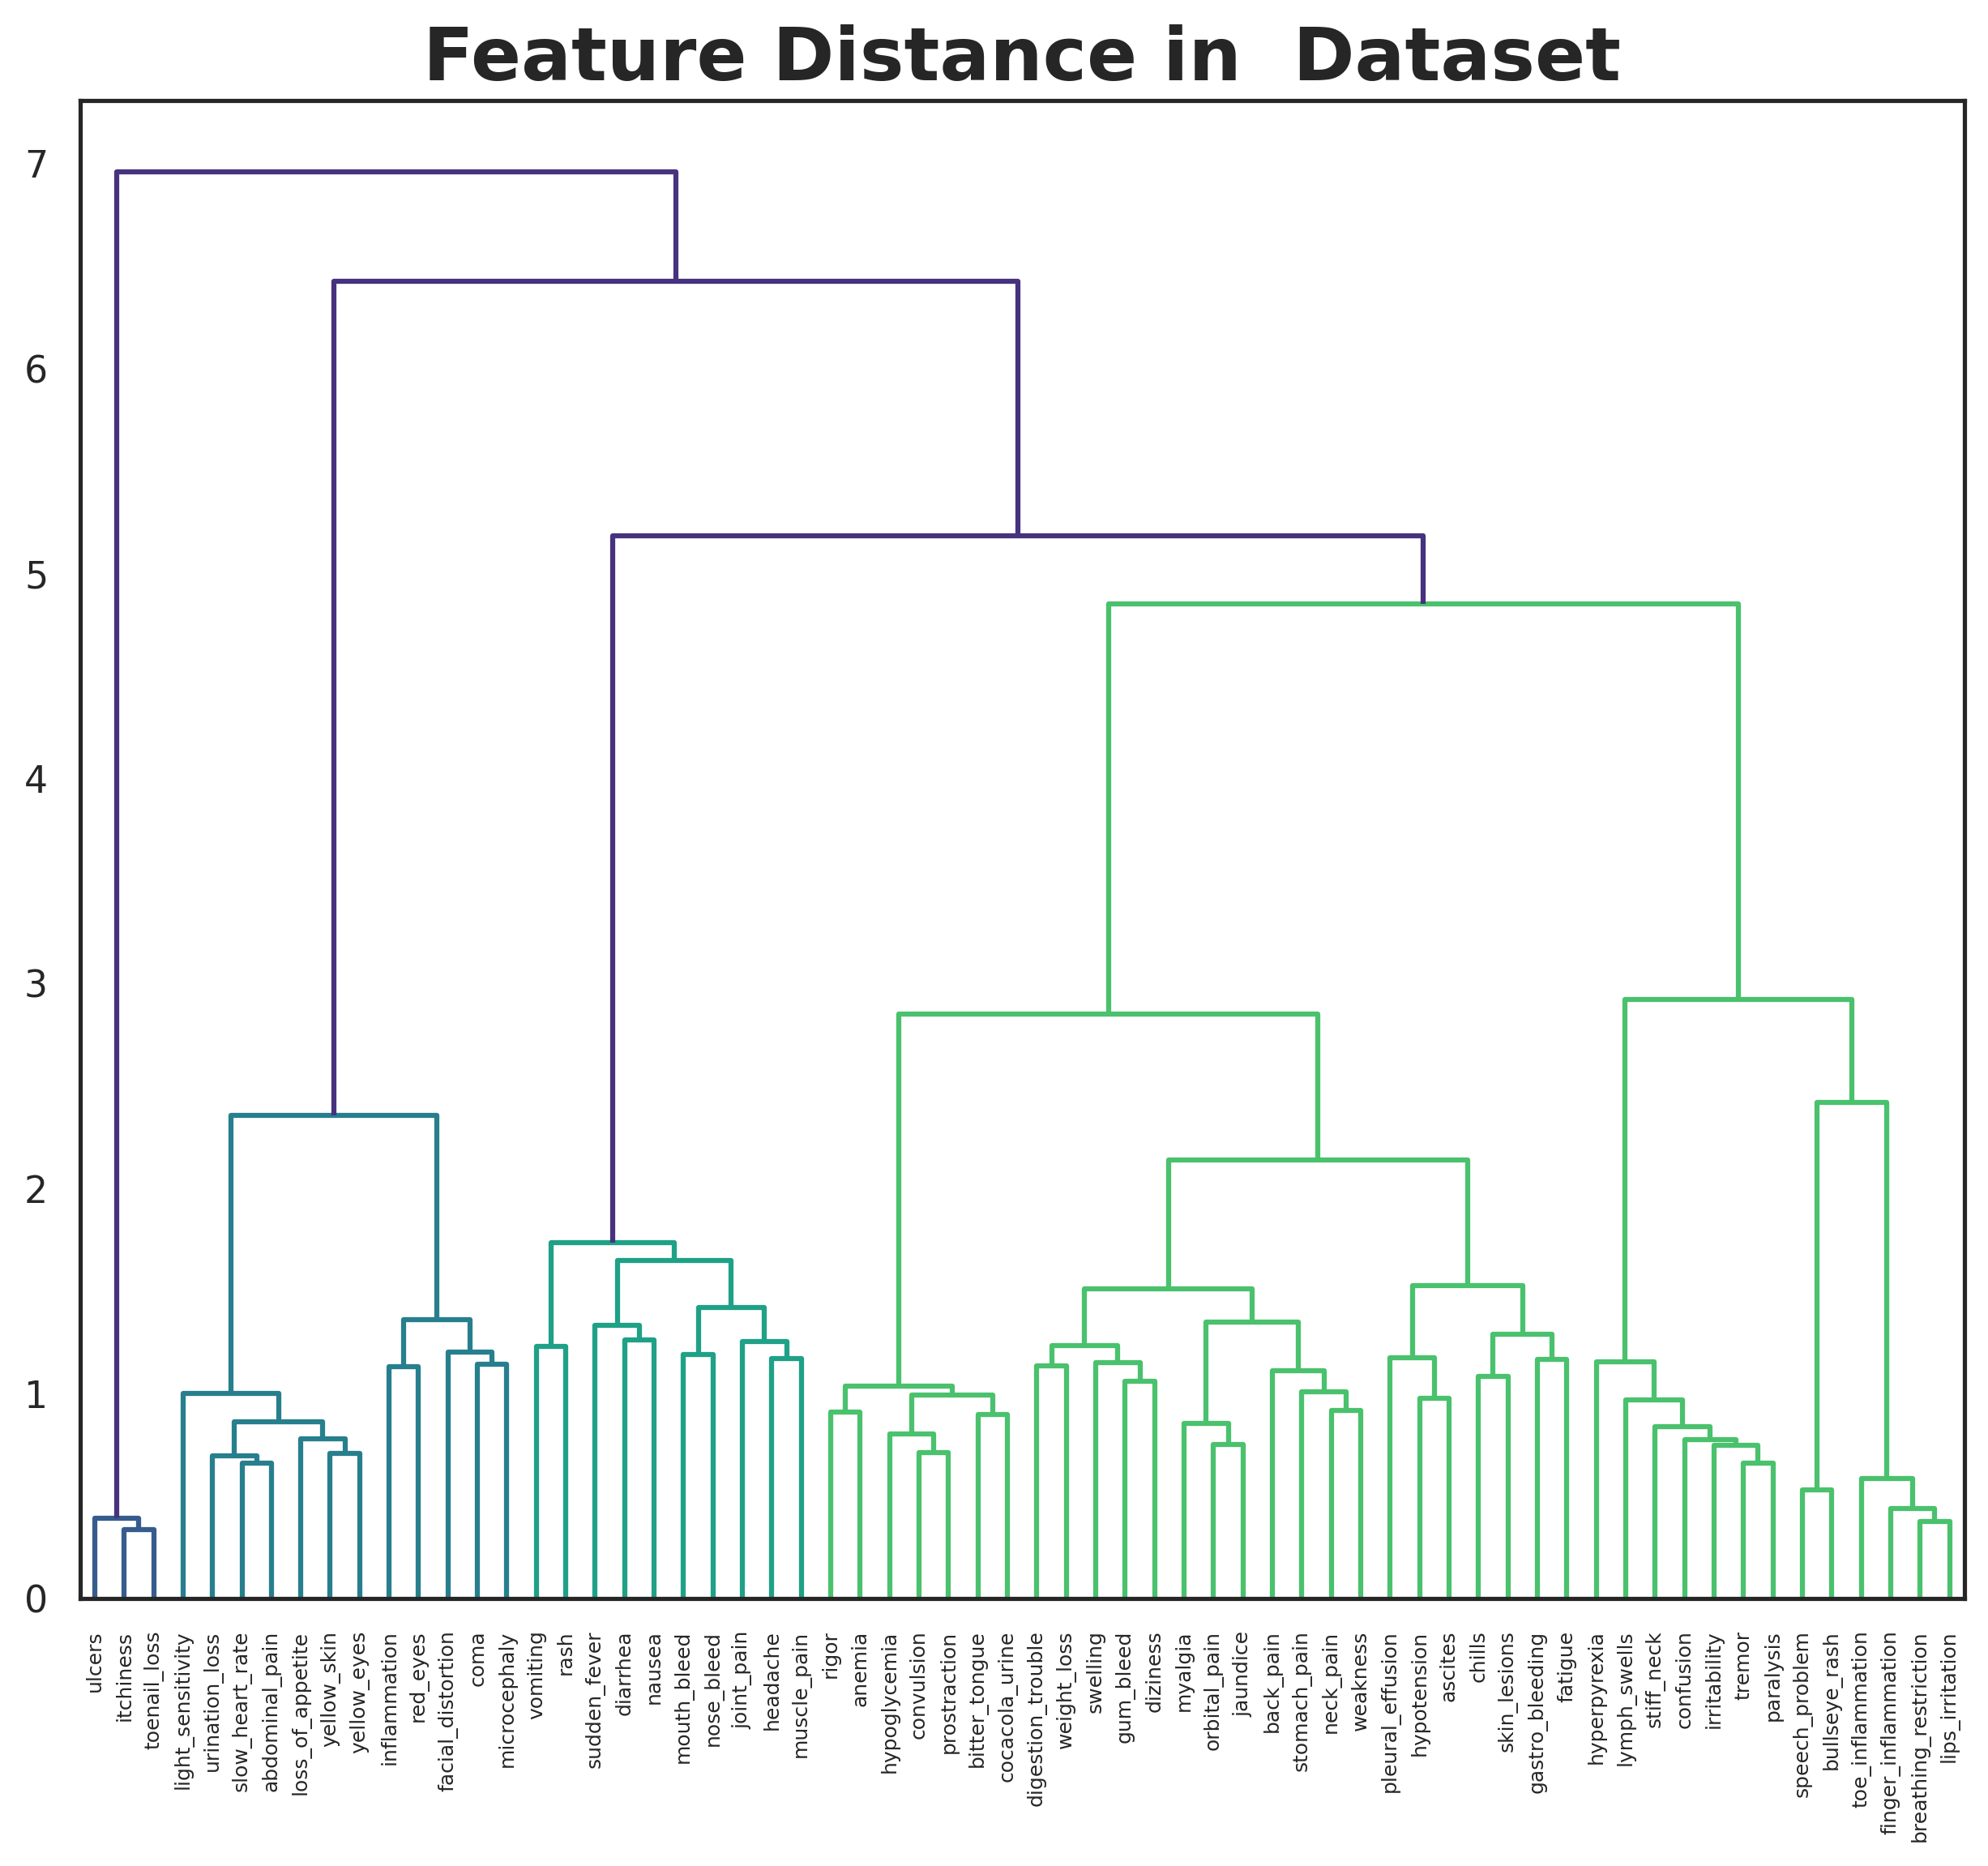

In [34]:
distance(train)

In [1]:
#We next proceed to check to potential duplicated observations that may appear in the train and test datasets

to_consider = train.drop(columns = ['prognosis'], axis = 1).columns.tolist()

train_dup = train.drop(columns = ['prognosis'], axis = 1).drop_duplicates()
test_dup = test.drop_duplicates()
duplicates = pd.merge(train_dup, test_dup, on = to_consider)

print('There are', duplicates.shape[0], 'rows that appear in the train and test dataset.\n')

NameError: name 'train' is not defined